In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [4]:
from freq_domain import plotspec
from wavegen import cosine_wave
from utilities import db
from transmitter import pulse_shaped
from carrier_recovery import estimate_carrier_with_fft

## 10.1 Estimation Using FFT

In [5]:
N = 10000 # num symbols
M = 20 # oversampling factor
Ts = 0.0001 # sampling frequency

fc = 1000 # Carrier frequency
phi = -1  # Phase offset

In [6]:
duration = Ts*M*N
t, carrier = cosine_wave(fc, duration, Ts, phi)

In [7]:
symbols = np.random.choice([-3, -1, 1, 3], N) # 4-PAM
waveform = pulse_shaped(symbols, M)
modulated_suppr_carrier = waveform * carrier
modulated_large_carrier = (1 + waveform) * carrier

### Large carrier

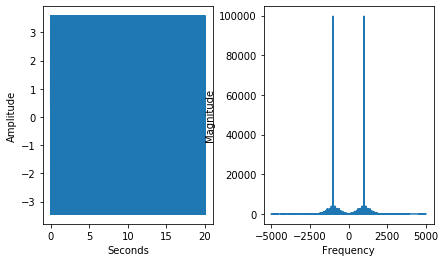

In [8]:
plotspec(modulated_large_carrier, Ts);

In [9]:
freq, phase = estimate_carrier_with_fft(modulated_large_carrier, Ts)
print(f'Estimated carrier freq = {freq}, Actual carrier freq = {fc}')
print(f'Estimated carrier pahse = {phase:.2f}, Actual carrier phase = {phi}')

Estimated carrier freq = 1000.0, Actual carrier freq = 1000
Estimated carrier pahse = -1.00, Actual carrier phase = -1


### Suppressed Carrier

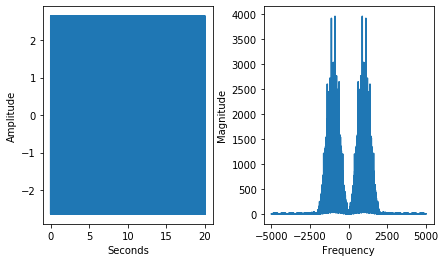

In [10]:
plotspec(modulated_suppr_carrier, Ts);

In [11]:
# Above method does not work with suppressed carrier
# Remember that even a 0.01 frequency offset can be catastrophic
freq, phase = estimate_carrier_with_fft(modulated_suppr_carrier, Ts)
print(f'Estimated carrier freq = {freq}, Actual carrier freq = {fc}')
print(f'Estimated carrier pahse = {phase:.2f}, Actual carrier phase = {phi}')

Estimated carrier freq = 1117.0, Actual carrier freq = 1000
Estimated carrier pahse = -0.40, Actual carrier phase = -1


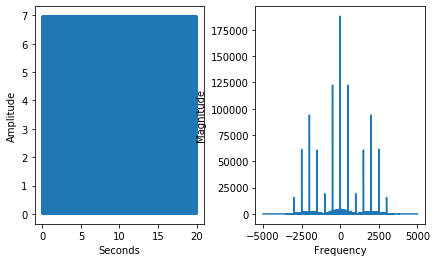

In [12]:
# Spectrum with a square non-linearity
plotspec(modulated_suppr_carrier**2, Ts);

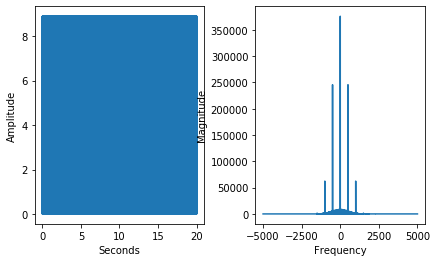

In [13]:
# The DC component is the non-zero average of the squared waveform.
# The spike at 500 Hz is because the symbol is generated by a square wave
# with symbol period = Ts * M = 0.002 secs, or freq = 500 Hz
plotspec(waveform**2, Ts);

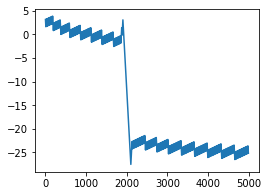

In [14]:
squared_signal = modulated_suppr_carrier ** 2 # Use a square non-linearity
# Create bandpass filter at twice the carrier frequency
taps = 500
Fs = 1/Ts
band_edges = [0, 1900, 1950, 2050, 2100, 5000]
damps = [0, 1, 0]
bpf = signal.remez(taps, band_edges, damps, fs=Fs)
w, h = signal.freqz(bpf,1, fs=Fs)
preprocessed = signal.lfilter(bpf, 1, squared_signal)
plt.plot(w, np.unwrap(np.angle(h)));

In [15]:
# Now use the fft method
freq_2x, phase_2x_with_bpf = estimate_carrier_with_fft(preprocessed, Ts)
freq = freq_2x/2
# Account for BPF phase
idx = np.abs(w - freq_2x).argmin()
bpf_phase = np.angle(h[idx])
phase = (phase_2x_with_bpf - bpf_phase)/2
print(f'Estimated carrier freq = {freq}, Actual carrier freq = {fc}')
print(f'Estimated carrier pahse = {phase:.2f}, Actual carrier phase = {phi}')

Estimated carrier freq = 1000.0, Actual carrier freq = 1000
Estimated carrier pahse = -0.85, Actual carrier phase = -1


## 10.2 Squared Difference Loop

In [16]:
# Carrier parameters
Ts = 1/10000
duration = 1
fc = 100
ph_offset = -0.8

t, squared_carrier = cosine_wave(2*fc, duration, Ts, 2*ph_offset)



array([-0.8, -0.8, -0.8, -0.8, -0.8])

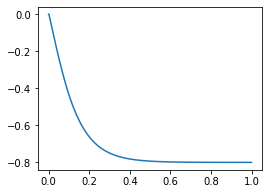

In [17]:
# Adaptive parameters
mu = 0.001
window_len = 25
f0 = fc # Frequency is supposed to be known perfectly
initial_phase_estimate = 0

theta = np.zeros_like(t)
theta[0] = initial_phase_estimate
avg_filter = np.ones(window_len)/window_len 
buffer = np.zeros_like(avg_filter)

for k, tick in enumerate(t[:-1]):
    deriv = ((squared_carrier[k] - np.cos(4*np.pi*f0*tick + 2*theta[k]))*
            np.sin(4*np.pi*f0*tick + 2*theta[k]))
    buffer = np.roll(buffer, 1)
    buffer[0] = deriv
    theta[k+1] = theta[k] - mu*np.dot(avg_filter, buffer)
    
plt.plot(t, theta);
theta[-5:]